### This is a repeat assignment. I have used the pytreebank package last time to get the SST dataset. Here we will create the dataset on our own.

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')

# import pytreebank

# import google_trans_new 
# from google_trans_new import google_translator  
import random

import os, pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Get the raw data

In [4]:
! wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

--2021-06-15 01:54:27--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-06-15 01:54:27--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  2.31MB/s    in 2.6s    

2021-06-15 01:54:30 (2.31 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]



In [5]:
!unzip stanfordSentimentTreebank.zip

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stanfo

## Load Dataset into dataframes

In [102]:
# Get Sentiment Labels
sentiment_labels = pd.read_csv('/content/stanfordSentimentTreebank/sentiment_labels.txt',names=['phrase_id','sentiment_values'], sep = "|", header = 0)

In [103]:
sentiment_labels.head()

,phrase_id,sentiment_values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [104]:
# Convert label values to 5 buckets
n_bins = 5
sentiment_labels['sentiment_values'] = pd.cut(sentiment_labels['sentiment_values'], n_bins, labels = np.arange(5),retbins=True)[0]
sentiment_labels.head()

,phrase_id,sentiment_values
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


In [105]:
# Get Sentence Ids
sentence_ids = pd.read_csv('/content/stanfordSentimentTreebank/datasetSentences.txt', sep = "\t")

In [106]:
sentence_ids.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [107]:
# Get Dictionary
dictionary = pd.read_csv('/content/stanfordSentimentTreebank/dictionary.txt', sep = "|", names = ['phrase', 'phrase_id'])

In [108]:
dictionary.head()

,phrase,phrase_id
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [109]:
# Get dataset split
train_test_split = pd.read_csv('/content/stanfordSentimentTreebank/datasetSplit.txt')

In [110]:
train_test_split.head()

,sentence_index,splitset_label
0,1,1
1,2,1
2,3,2
3,4,2
4,5,2


### In this dataset, each sentence is split into lowest level phrases/tokens and these phrases are proivided the sentiments. These leaf level nodes are merged to get the sentiment of next level and this goes up till the entire sentence. Hence the dictionary contains all sentences with the sentiment as top level phrase or node. We can do an inner join to find these phrases.

In [111]:
sentence_phrase_map = pd.merge(sentence_ids, dictionary, left_on='sentence', right_on='phrase')
sentence_phrase_map.head()

,sentence_index,sentence,phrase,phrase_id
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999


### As we need to get the sentiment of the sentences and sentiments are maintained at phrase level, we will do the inner join to get the sentiment of sentences using the df from above step

In [112]:
sentence_sentiment = pd.merge(sentence_phrase_map, sentiment_labels, left_on='phrase_id', right_on='phrase_id')

In [113]:
sentence_sentiment.head()

,sentence_index,sentence,phrase,phrase_id,sentiment_values
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,3
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,4
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,2
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,3
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,4


### To get the train test split, we will use the train_test split dataset which has got the sentence index and split label

In [114]:
sst_dataset = pd.merge(sentence_sentiment, train_test_split, left_on= 'sentence_index', right_on = 'sentence_index')

In [115]:
sst_dataset.head()

,sentence_index,sentence,phrase,phrase_id,sentiment_values,splitset_label
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,3,1
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,4,1
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,2,2
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,3,2
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,4,2


In [116]:
sst_dataset_train = sst_dataset[sst_dataset.splitset_label == 1]
sst_dataset_test = sst_dataset[sst_dataset.splitset_label == 2]

In [122]:
train = sst_dataset_train.drop(['sentence_index','phrase','phrase_id','splitset_label'],axis = 1)
test = sst_dataset_test.drop(['sentence_index','phrase','phrase_id','splitset_label'],axis = 1)

In [123]:
len(train), len(test)

(8117, 2125)

In [124]:
train.head()

,sentence,sentiment_values
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
60,Singer\/composer Bryan Adams contributes a sle...,3
61,You 'd think by now America would have had eno...,2
62,Yet the act is still charming here .,3


In [125]:
train['sentiment_values'].value_counts()

3    2216
1    2092
2    1549
4    1230
0    1030
Name: sentiment_values, dtype: int64

[Text(0.5, 0, 'Sentiment Value')]

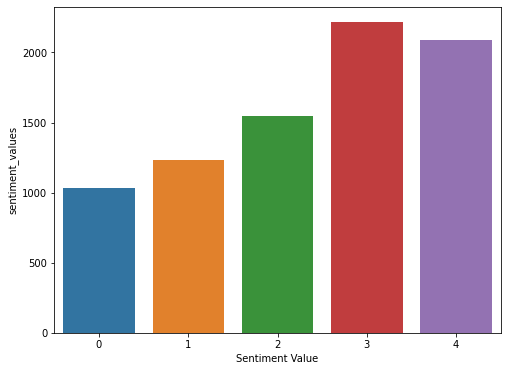

In [126]:
fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=train['sentiment_values'].unique(), y=train['sentiment_values'].value_counts())

ax.set(xlabel = 'Sentiment Value')